# Note
* 전처리는 여러 방법으로 다시 해봤는데 그냥 처음 베이스라인 전처리가 가장 좋아서 back to basic...
* 불균형 데이터를 오버샘플링 말고 stratified k-fold로 해결하고 싶었는데 사용법이 좀 잘못된 것 같아요.. 
* Stacking은 데이터가 적은 경우 특히 오버피팅 되기 쉽다고해서 그냥 생략했습니다.
* randomforest/xgboost/lightgbm/catboost -> 최종 모델은 lgbm으로 정했습니다.(accuracy=0.8960)
* 성능 더 높이고 싶으면 lgbm에서 파라미터 튜닝을 더 하던가 stratified를 제대로 적용해봐도 좋을 것 같아요.
* 근데 튜닝은 제가 대충 해봤는데 90%를 계속 못넘더라고요? ㅠㅠ
* lgbm document: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

# Load

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('loan.csv')
df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0


# Preprocessing

### 기본 작업

In [3]:
# 불필요한 features 삭제
df = df.drop(['Unnamed: 0', 'Loan_ID'], axis=1)

In [4]:
# Total_Income 변환
for i in range(len(df['Total_Income'])):
    df['Total_Income'][i] = float(df['Total_Income'][i].strip('$'))
    
df['Total_Income'] = df['Total_Income'].astype(float)

In [5]:
# Credit_History 변환
df['Credit_History'] = df['Credit_History'].astype(object)

In [6]:
# features/label 분리
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [7]:
# y도 one-hot encoding
y.replace(to_replace={'N':0, 'Y':1}, inplace=True)

In [8]:
# 연속형 피처 리스트 저장
num_col = list(X._get_numeric_data().columns)

# 범주형 피처 리스트 저장
cat_col = list(X.columns)
for col in num_col:
    cat_col.remove(col)         

### 결측치 처리
* 데이터가 얼마 없으므로 결측치도 최대한 살려서 진행

In [9]:
# # 결측치 처리1 - 평균(수치형), 최빈값(범주형) 처리
# def meanMode(X):
    
#     from scipy.stats import mode
    
#     # 연속형 피처 리스트 저장
#     num_col = list(X._get_numeric_data().columns)

#     # 범주형 피처 리스트 저장
#     cat_col = list(X.columns)
#     for col in num_col:
#         cat_col.remove(col)

#     # 연속형 데이터 전처리(평균값으로 채우기)
#     for col in num_col:
#         X[col].fillna(round(np.mean(X[col])), inplace=True)

#     # 범주형 데이터 전처리 (최빈값으로 채우기)
#     for col in cat_col:
#         X[col].fillna(mode(X[col])[0][0], inplace=True)
        
#     return X
        
# X = meanMode(X)

In [10]:
# # 결측치 처리2 - 결측행 제거
# def delNaN(X):
#     X = X.dropna(how='any', axis=0).reset_index()
#     return X

# X = delNaN(X)

In [11]:
# 연속형 데이터 결측값 처리: 평균값으로 채우기
for col in num_col:
    X[col].fillna(round(np.mean(X[col])), inplace=True)

# 범주형 데이터 결측값 처리: 최빈값으로 채우기
for col in cat_col:
    X[col].fillna(X[col].mode()[0], inplace=True)

### 표준화

In [12]:
# from sklearn.preprocessing import StandardScaler
    
# # StandardScaler 객체 생성
# scaler = StandardScaler()

# # StandardScaler로 표준화
# X_scaled = scaler.fit_transform(X[num_col])

# # Numpy ndarray -> DataFrame 변환
# X_scaled_df = pd.DataFrame(data=X_scaled, columns=num_col)

# # 스케일링한 결과 X로 합치기
# X.drop(num_col, axis=1, inplace=True)
# X = pd.concat([X, X_scaled_df], axis=1)

In [13]:
for num in num_col:
    X[num] = np.log1p(X[num]) 

### 이상치 처리 
* 하고 성능이 더 안 좋아져서 패스
* 아무래도 극단적인 값도 유의미한 데이터 같아서 안 지우는게 나은 듯

In [14]:
# # zscore 변수 생성
# from scipy import stats
# X['z_ApplicantIncome'] = stats.zscore(X['ApplicantIncome'])
# X['z_Total_Income'] = stats.zscore(X['Total_Income'])

# # 약 95% 신뢰구간 내에 있는 데이터만 선택
# df = pd.concat([X, y], axis=1)
# df = df[df['z_ApplicantIncome'].between(-2, 2)]
# df = df[df['z_Total_Income'].between(-2, 2)]

# # zscore 변수 제거
# df = df.drop('z_ApplicantIncome', axis=1, inplace=False)
# df = df.drop('z_Total_Income', axis=1, inplace=False)

# # 다시 X/y 분리
# X = df.drop('Loan_Status', axis=1)
# y = df['Loan_Status']

### 정규화

In [15]:
# from sklearn.preprocessing import MinMaxScaler

# # 연속형 피처 리스트 저장
# num_col = list(X._get_numeric_data().columns)

# # MinMaxScaler 객체 생성
# scaler = MinMaxScaler()

# # MinMaxScaler로 표준화
# X_scaled = scaler.fit_transform(X[num_col])

# # Numpy ndarray -> DataFrame 변환
# X_scaled_df = pd.DataFrame(data=X_scaled, columns=num_col) 

# # 스케일링한 결과 X로 합치기
# X.drop(num_col, axis=1, inplace=True)
# X = pd.concat([X, X_scaled_df], axis=1)

### 인코딩
* 원핫보다는 레이블 인코딩이 성능이 좋게 나오는 듯

In [16]:
# # 인코딩1 - 레이블 인코딩
# def LabelEncode(X):
    
#     from sklearn.preprocessing import LabelEncoder
    
#     # 연속형 피처 리스트 저장
#     num_col = list(X._get_numeric_data().columns)

#     # 범주형 피처 리스트 저장
#     cat_col = list(X.columns)
#     for col in num_col:
#         cat_col.remove(col)
        
#     encoder = LabelEncoder()
#     for cat in cat_col:
#         X[cat] = encoder.fit_transform(X[cat])

#     return X

# X = LabelEncode(X)

In [17]:
# # 인코딩2 - 원-핫 인코딩
# def OneHotEncode(X):
    
#     from sklearn.preprocessing import OneHotEncoder
    
#     object_col = []
#     for col in X.columns:
#         if X[col].dtype == 'object':
#             object_col.append(col)

#     enc = OneHotEncoder()
#     enc.fit(X.loc[:,object_col])

#     onehot_X = pd.DataFrame(enc.transform(X.loc[:,object_col]).toarray(), 
#                                    columns = enc.get_feature_names(object_col))
#     X.drop(object_col, axis=1, inplace=True)
#     X = pd.concat([X, onehot_X], axis=1)
    
#     return X

# X = OneHotEncode(X)

In [18]:
# 범주형 데이터 인코딩: 원-핫 인코딩
# X = pd.get_dummies(X)

In [19]:
# 범주형 데이터 인코딩: 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for cat in cat_col:
    X[cat] = encoder.fit_transform(X[cat])

### 불균형 데이터 처리
* 아니면 stratified k-fold로만

In [20]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

randomsample= RandomOverSampler()
X, y = randomsample.fit_sample(X, y)

In [21]:
# SMOTE -> 효과 별로?
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# X, y = SMOTE().fit_resample(X, y)

# Modeling

### 기본 작업

In [22]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [23]:
# train/test set 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

In [24]:
# # train/val set 분리 
# from sklearn.model_selection import train_test_split
# X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=2)

In [25]:
# StratifiedKFold 준비
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

In [26]:
# 평가 지표 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('\n정확도: {0:.4f}\n정밀도: {1:.4f}\n재현율: {2:.4f}\nF1: {3:.4f}\nROC: {3:.4f}'.format(accuracy, precision, recall, f1, roc_score))

### RandomForest
* stratified O / randomoversampling -> 0.99
* 근데 이건 뭔가 잘못된 것 같음
* train/test에서 train을 다시 train/val로 나누고 stratified 해야되나?

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=2)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print('Accuracy Score: {:0.4f}'.format(accuracy_score(y_test, rf_preds)))

Accuracy Score: 0.8786


In [27]:
# stratified k-fold: 뭔가 잘못된 듯?
outcomes = []

for n_fold, (train_index, test_index)  in enumerate(folds.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    rdf = RandomForestClassifier(random_state=2)
    rdf.fit(X_train, y_train)
    preds = rdf.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    outcomes.append(acc)
   
np.mean(outcomes)

0.9901734104046243

In [211]:
# outcomes = []

# for n_fold, (train_index, val_index)  in enumerate(folds.split(X_train, y_train)):
#     X_val_train, X_val_test = X_train.iloc[train_index], X_train.iloc[val_index]
#     y_val_train, y_val_test = y_train.iloc[train_index], y_train.iloc[val_index]
#     rdf = RandomForestClassifier(random_state=2)
#     rdf.fit(X_val_train, y_val_train)
#     preds = rdf.predict(X_val_test)
    
#     acc = accuracy_score(y_val_test, preds)
#     outcomes.append(acc)
   
# np.mean(outcomes)

In [212]:
get_clf_eval(y_test, pred=preds)

오차 행렬
[[81  1]
 [ 0 91]]

정확도: 0.9942
정밀도: 0.9891
재현율: 1.0000
F1: 0.9945


### XGBoost

In [27]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=1000, random_state=2)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print('Accuracy Score: {:0.4f}'.format(accuracy_score(y_test, xgb_preds)))

Accuracy Score: 0.8439


In [214]:
outcomes = []

for n_fold, (train_index, test_index)  in enumerate(folds.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    xgb = XGBClassifier(n_estimators=1000, random_state=2)
    xgb.fit(X_train, y_train,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=100)
    preds = xgb.predict(X_test)

    acc = accuracy_score(y_test, preds)
    outcomes.append(acc)

np.mean(outcomes)

[0]	validation_0-error:0.252818	validation_1-error:0.304348
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[100]	validation_0-error:0.083736	validation_1-error:0.130435
Stopping. Best iteration:
[135]	validation_0-error:0.05153	validation_1-error:0.072464

[0]	validation_0-error:0.270531	validation_1-error:0.246377
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[100]	validation_0-error:0.099839	validation_1-error:0.144928
Stopping. Best iteration:
[98]	validation_0-error:0.099839	validation_1-error:0.130435

[0]	validation_0-error:0.257649	validation_1-error:0.231884
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[100]	validation_0-error:0.072464	val

0.8492753623188406

In [215]:
get_clf_eval(y_test, pred=preds)

오차 행렬
[[26  9]
 [ 4 30]]

정확도: 0.8116
정밀도: 0.7692
재현율: 0.8824
F1: 0.8219


### LightGBM
* stratified X / randomoversampling -> 0.8844

In [27]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=1000, random_state=2)
lgbm.fit(X_train, y_train)
lgbm_preds = lgbm.predict(X_test)
print('Accuracy Score: {:0.4f}'.format(accuracy_score(y_test, lgbm_preds)))

Accuracy Score: 0.8844


In [72]:
outcomes = []

for n_fold, (train_index, test_index)  in enumerate(folds.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lgbm = LGBMClassifier(n_estimators=3000, random_state=2)
    lgbm.fit(X_train, y_train,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=100)
    preds = lgbm.predict(X_test)

    acc = accuracy_score(y_test, preds)
    outcomes.append(acc)

np.mean(outcomes)

Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0641934	valid_1's binary_logloss: 0.325516
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.135952	valid_1's binary_logloss: 0.294801
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.068123	valid_1's binary_logloss: 0.315749
[200]	training's binary_logloss: 0.0135824	valid_1's binary_logloss: 0.306321
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0259336	valid_1's binary_logloss: 0.293256
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0628356	valid_1's binary_logloss: 0.304601
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0628356	valid_1's binary_logloss: 0.304601
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0692258	valid_1's binary_logloss: 0.338887
Early stopping, best iteration

0.8927536231884059

In [90]:
get_clf_eval(y_test, pred=preds)

오차 행렬
[[ 6 10]
 [ 3 31]]

정확도: 0.7400
정밀도: 0.7561
재현율: 0.9118
F1: 0.8267


### CatBoost
* 범주형 따로 encoding 안하고 catboost로 encoding
* 다른 모델보다 시간 좀 걸림

In [235]:
cat_features = [f for f in X.columns if X[f].dtype == 'object']

from catboost import CatBoostClassifier
cat = CatBoostClassifier(n_estimators=1000, random_state=2)
cat.fit(X_train, y_train, cat_features=cat_features, early_stopping_rounds=50)
cat_preds = cat.predict(X_test)
print('Accuracy Score: {:0.4f}'.format(accuracy_score(y_test, cat_preds)))

Learning rate set to 0.008406
0:	learn: 0.6898464	total: 30.7ms	remaining: 30.7s
1:	learn: 0.6863531	total: 63.7ms	remaining: 31.8s
2:	learn: 0.6829902	total: 94.9ms	remaining: 31.6s
3:	learn: 0.6801260	total: 116ms	remaining: 28.8s
4:	learn: 0.6770590	total: 148ms	remaining: 29.5s
5:	learn: 0.6738719	total: 180ms	remaining: 29.9s
6:	learn: 0.6712196	total: 193ms	remaining: 27.3s
7:	learn: 0.6679524	total: 228ms	remaining: 28.3s
8:	learn: 0.6649710	total: 257ms	remaining: 28.3s
9:	learn: 0.6624869	total: 268ms	remaining: 26.5s
10:	learn: 0.6586403	total: 295ms	remaining: 26.5s
11:	learn: 0.6550910	total: 324ms	remaining: 26.7s
12:	learn: 0.6527722	total: 335ms	remaining: 25.4s
13:	learn: 0.6499380	total: 363ms	remaining: 25.6s
14:	learn: 0.6466198	total: 395ms	remaining: 25.9s
15:	learn: 0.6440118	total: 424ms	remaining: 26.1s
16:	learn: 0.6408300	total: 452ms	remaining: 26.1s
17:	learn: 0.6377825	total: 483ms	remaining: 26.3s
18:	learn: 0.6353313	total: 512ms	remaining: 26.4s
19:	lear

166:	learn: 0.4553420	total: 5.95s	remaining: 29.7s
167:	learn: 0.4551604	total: 5.96s	remaining: 29.5s
168:	learn: 0.4544621	total: 5.99s	remaining: 29.4s
169:	learn: 0.4540375	total: 6.02s	remaining: 29.4s
170:	learn: 0.4533284	total: 6.05s	remaining: 29.3s
171:	learn: 0.4522308	total: 6.08s	remaining: 29.2s
172:	learn: 0.4519743	total: 6.1s	remaining: 29.2s
173:	learn: 0.4515235	total: 6.13s	remaining: 29.1s
174:	learn: 0.4512410	total: 6.16s	remaining: 29s
175:	learn: 0.4506637	total: 6.18s	remaining: 28.9s
176:	learn: 0.4495131	total: 6.21s	remaining: 28.9s
177:	learn: 0.4486938	total: 6.23s	remaining: 28.8s
178:	learn: 0.4483320	total: 6.26s	remaining: 28.7s
179:	learn: 0.4474433	total: 6.28s	remaining: 28.6s
180:	learn: 0.4471570	total: 6.31s	remaining: 28.5s
181:	learn: 0.4470747	total: 6.32s	remaining: 28.4s
182:	learn: 0.4468552	total: 6.34s	remaining: 28.3s
183:	learn: 0.4463496	total: 6.36s	remaining: 28.2s
184:	learn: 0.4458190	total: 6.39s	remaining: 28.2s
185:	learn: 0.4

326:	learn: 0.3880427	total: 10.1s	remaining: 20.8s
327:	learn: 0.3880200	total: 10.1s	remaining: 20.7s
328:	learn: 0.3873596	total: 10.1s	remaining: 20.7s
329:	learn: 0.3872911	total: 10.2s	remaining: 20.6s
330:	learn: 0.3871682	total: 10.2s	remaining: 20.6s
331:	learn: 0.3868798	total: 10.2s	remaining: 20.6s
332:	learn: 0.3863479	total: 10.3s	remaining: 20.5s
333:	learn: 0.3859705	total: 10.3s	remaining: 20.5s
334:	learn: 0.3855339	total: 10.3s	remaining: 20.5s
335:	learn: 0.3853673	total: 10.4s	remaining: 20.5s
336:	learn: 0.3845709	total: 10.4s	remaining: 20.4s
337:	learn: 0.3845453	total: 10.4s	remaining: 20.4s
338:	learn: 0.3844400	total: 10.4s	remaining: 20.3s
339:	learn: 0.3840544	total: 10.5s	remaining: 20.3s
340:	learn: 0.3837956	total: 10.5s	remaining: 20.3s
341:	learn: 0.3837647	total: 10.5s	remaining: 20.2s
342:	learn: 0.3836403	total: 10.5s	remaining: 20.2s
343:	learn: 0.3832840	total: 10.6s	remaining: 20.1s
344:	learn: 0.3832191	total: 10.6s	remaining: 20.1s
345:	learn: 

490:	learn: 0.3478913	total: 14.5s	remaining: 15s
491:	learn: 0.3478355	total: 14.5s	remaining: 15s
492:	learn: 0.3474282	total: 14.5s	remaining: 14.9s
493:	learn: 0.3473465	total: 14.5s	remaining: 14.9s
494:	learn: 0.3473215	total: 14.5s	remaining: 14.8s
495:	learn: 0.3470406	total: 14.6s	remaining: 14.8s
496:	learn: 0.3466673	total: 14.6s	remaining: 14.8s
497:	learn: 0.3463103	total: 14.6s	remaining: 14.7s
498:	learn: 0.3456378	total: 14.7s	remaining: 14.7s
499:	learn: 0.3454980	total: 14.7s	remaining: 14.7s
500:	learn: 0.3454826	total: 14.7s	remaining: 14.7s
501:	learn: 0.3452221	total: 14.7s	remaining: 14.6s
502:	learn: 0.3452044	total: 14.8s	remaining: 14.6s
503:	learn: 0.3449825	total: 14.8s	remaining: 14.6s
504:	learn: 0.3447305	total: 14.8s	remaining: 14.5s
505:	learn: 0.3446764	total: 14.8s	remaining: 14.5s
506:	learn: 0.3441543	total: 14.9s	remaining: 14.5s
507:	learn: 0.3439310	total: 14.9s	remaining: 14.4s
508:	learn: 0.3434306	total: 14.9s	remaining: 14.4s
509:	learn: 0.34

652:	learn: 0.3147829	total: 18.6s	remaining: 9.9s
653:	learn: 0.3147214	total: 18.7s	remaining: 9.87s
654:	learn: 0.3145410	total: 18.7s	remaining: 9.84s
655:	learn: 0.3143268	total: 18.7s	remaining: 9.8s
656:	learn: 0.3140696	total: 18.7s	remaining: 9.78s
657:	learn: 0.3136737	total: 18.8s	remaining: 9.75s
658:	learn: 0.3134245	total: 18.8s	remaining: 9.72s
659:	learn: 0.3132715	total: 18.8s	remaining: 9.69s
660:	learn: 0.3130953	total: 18.8s	remaining: 9.66s
661:	learn: 0.3129371	total: 18.9s	remaining: 9.63s
662:	learn: 0.3127807	total: 18.9s	remaining: 9.6s
663:	learn: 0.3126782	total: 18.9s	remaining: 9.57s
664:	learn: 0.3126357	total: 18.9s	remaining: 9.54s
665:	learn: 0.3121464	total: 19s	remaining: 9.51s
666:	learn: 0.3119863	total: 19s	remaining: 9.48s
667:	learn: 0.3117012	total: 19s	remaining: 9.45s
668:	learn: 0.3117011	total: 19s	remaining: 9.42s
669:	learn: 0.3113573	total: 19.1s	remaining: 9.39s
670:	learn: 0.3112408	total: 19.1s	remaining: 9.36s
671:	learn: 0.3110832	t

817:	learn: 0.2797616	total: 23s	remaining: 5.12s
818:	learn: 0.2794564	total: 23s	remaining: 5.09s
819:	learn: 0.2792388	total: 23.1s	remaining: 5.06s
820:	learn: 0.2790521	total: 23.1s	remaining: 5.03s
821:	learn: 0.2787678	total: 23.1s	remaining: 5s
822:	learn: 0.2784159	total: 23.1s	remaining: 4.97s
823:	learn: 0.2778488	total: 23.2s	remaining: 4.95s
824:	learn: 0.2777585	total: 23.2s	remaining: 4.92s
825:	learn: 0.2775604	total: 23.2s	remaining: 4.89s
826:	learn: 0.2772277	total: 23.2s	remaining: 4.86s
827:	learn: 0.2770216	total: 23.3s	remaining: 4.83s
828:	learn: 0.2766425	total: 23.3s	remaining: 4.8s
829:	learn: 0.2764639	total: 23.3s	remaining: 4.78s
830:	learn: 0.2763910	total: 23.3s	remaining: 4.75s
831:	learn: 0.2761759	total: 23.4s	remaining: 4.72s
832:	learn: 0.2761163	total: 23.4s	remaining: 4.69s
833:	learn: 0.2759345	total: 23.4s	remaining: 4.66s
834:	learn: 0.2755460	total: 23.4s	remaining: 4.63s
835:	learn: 0.2754038	total: 23.5s	remaining: 4.61s
836:	learn: 0.275047

977:	learn: 0.2429784	total: 27.3s	remaining: 615ms
978:	learn: 0.2428312	total: 27.4s	remaining: 587ms
979:	learn: 0.2425737	total: 27.4s	remaining: 559ms
980:	learn: 0.2424906	total: 27.4s	remaining: 531ms
981:	learn: 0.2420867	total: 27.5s	remaining: 504ms
982:	learn: 0.2419218	total: 27.5s	remaining: 476ms
983:	learn: 0.2415972	total: 27.5s	remaining: 448ms
984:	learn: 0.2413752	total: 27.6s	remaining: 420ms
985:	learn: 0.2412524	total: 27.6s	remaining: 392ms
986:	learn: 0.2411432	total: 27.6s	remaining: 364ms
987:	learn: 0.2410584	total: 27.6s	remaining: 336ms
988:	learn: 0.2408021	total: 27.7s	remaining: 308ms
989:	learn: 0.2403707	total: 27.7s	remaining: 280ms
990:	learn: 0.2401782	total: 27.7s	remaining: 252ms
991:	learn: 0.2399830	total: 27.8s	remaining: 224ms
992:	learn: 0.2397247	total: 27.8s	remaining: 196ms
993:	learn: 0.2396168	total: 27.8s	remaining: 168ms
994:	learn: 0.2394856	total: 27.9s	remaining: 140ms
995:	learn: 0.2393706	total: 27.9s	remaining: 112ms
996:	learn: 

In [236]:
cat_features = [f for f in X.columns if X[f].dtype == 'object']

outcomes = []

for n_fold, (train_index, test_index)  in enumerate(folds.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat = CatBoostClassifier(n_estimators=3000, random_state=2)
    cat.fit(X_train, y_train,
           cat_features=cat_features,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=100)
    preds = cat.predict(X_test)

    acc = accuracy_score(y_test, preds)
    outcomes.append(acc)
    
np.mean(outcomes)

Learning rate set to 0.017468
0:	learn: 0.6851451	test: 0.6851451	test1: 0.6858632	best: 0.6858632 (0)	total: 23.5ms	remaining: 1m 10s
100:	learn: 0.4319564	test: 0.4388159	test1: 0.4651098	best: 0.4651098 (100)	total: 2.33s	remaining: 1m 6s
200:	learn: 0.3604132	test: 0.3732784	test1: 0.4206804	best: 0.4206804 (200)	total: 4.89s	remaining: 1m 8s
300:	learn: 0.3159571	test: 0.3359795	test1: 0.3970213	best: 0.3970213 (300)	total: 7.4s	remaining: 1m 6s
400:	learn: 0.2660024	test: 0.2903249	test1: 0.3699968	best: 0.3699693 (398)	total: 9.89s	remaining: 1m 4s
500:	learn: 0.2220625	test: 0.2461682	test1: 0.3459881	best: 0.3459881 (500)	total: 12.6s	remaining: 1m 2s
600:	learn: 0.1858958	test: 0.2093646	test1: 0.3223889	best: 0.3223889 (600)	total: 15.6s	remaining: 1m 2s
700:	learn: 0.1581409	test: 0.1807068	test1: 0.3060471	best: 0.3056351 (698)	total: 18.9s	remaining: 1m 1s
800:	learn: 0.1378730	test: 0.1600189	test1: 0.3030797	best: 0.3011173 (763)	total: 21.7s	remaining: 59.5s
Stopped by

500:	learn: 0.2268116	test: 0.2449926	test1: 0.4307525	best: 0.4307525 (500)	total: 13.5s	remaining: 1m 7s
600:	learn: 0.1883772	test: 0.2061590	test1: 0.4183942	best: 0.4177319 (599)	total: 16.1s	remaining: 1m 4s
700:	learn: 0.1623780	test: 0.1799994	test1: 0.4061563	best: 0.4059292 (698)	total: 18.8s	remaining: 1m 1s
800:	learn: 0.1403150	test: 0.1580599	test1: 0.3976450	best: 0.3957530 (787)	total: 21.6s	remaining: 59.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3957530398
bestIteration = 787

Shrink model to first 788 iterations.
Learning rate set to 0.017468
0:	learn: 0.6849012	test: 0.6849012	test1: 0.6857287	best: 0.6857287 (0)	total: 24.7ms	remaining: 1m 14s
100:	learn: 0.4207049	test: 0.4288344	test1: 0.5229807	best: 0.5229750 (99)	total: 2.45s	remaining: 1m 10s
200:	learn: 0.3581234	test: 0.3770156	test1: 0.5169374	best: 0.5169374 (200)	total: 4.88s	remaining: 1m 7s
300:	learn: 0.3061171	test: 0.3324399	test1: 0.5080484	best: 0.5067944 (275)	total: 7

KeyboardInterrupt: 

In [119]:
get_clf_eval(y_test, pred=preds)

오차 행렬
[[ 6 10]
 [ 1 33]]

정확도: 0.7800
정밀도: 0.7674
재현율: 0.9706
F1: 0.8571


# Final Model

### LightGBM 

In [140]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=1000,
                      learning_rate=0.04,
                      num_leaves=15,
                      #min_child_weight=0.05,
                      random_state=2)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)
pred_proba = lgbm.predict_proba(X_test)

In [141]:
get_clf_eval(y_test, pred=pred)

오차 행렬
[[74  8]
 [10 81]]

정확도: 0.8960
정밀도: 0.9101
재현율: 0.8901
F1: 0.9000
ROC: 0.9000


### Precision & Recall

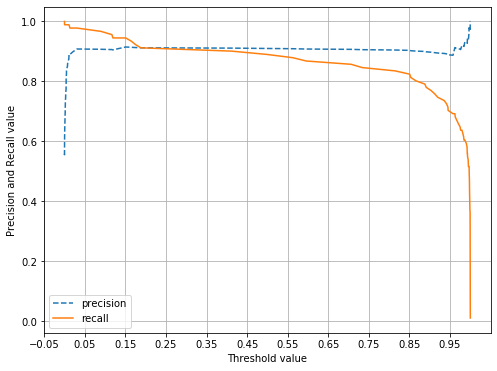

In [70]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):

    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0: thresholds_boundary], linestyle= '--', label='precision')
    plt.plot(thresholds, recalls[0: thresholds_boundary], label='recall')
    
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))

    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lgbm.predict_proba(X_test)[:,1])

### ROC Curve

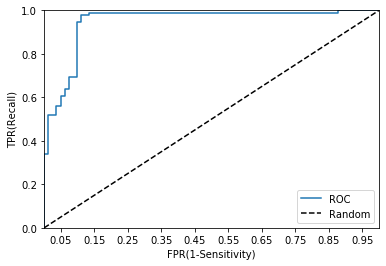

In [71]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds  = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])